In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

print(f"Runing on PyMC v{pm.__version__}")

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Runing on PyMC v4.0.0b2


In [2]:
%load_ext watermark
az.style.use("arviz-darkgrid")

(model_comparison)=
# Model comparison

To demonstrate the use of model comparison criteria in PyMC, we implement the **8 schools** example from Section 5.5 of Gelman et al (2003), which attempts to infer the effects of coaching on SAT scores of students from 8 schools. Below, we fit a **pooled model**, which assumes a single fixed effect across all schools, and a **hierarchical model** that allows for a random effect that partially pools the data.

The data include the observed treatment effects (`y`) and associated standard deviations (`sigma`) in the 8 schools.

In [3]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
J = len(y)

### Pooled model

In [4]:
with pm.Model() as pooled:

    # Latent pooled effect size
    mu = pm.Normal("mu", 0, sigma=1e6)

    obs = pm.Normal("obs", mu, sigma=sigma, observed=y)

    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


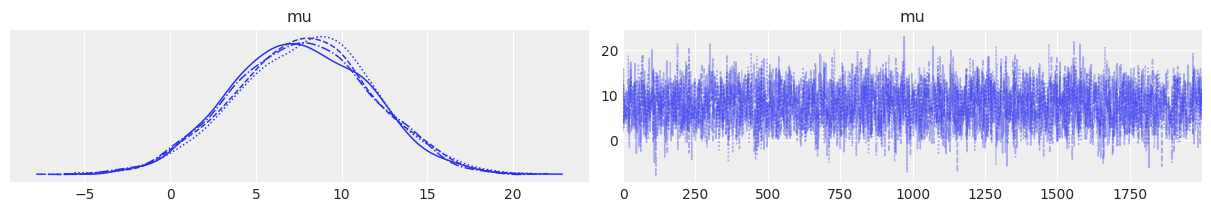

In [5]:
az.plot_trace(trace_p);

### Hierarchical model

In [6]:
with pm.Model() as hierarchical:

    eta = pm.Normal("eta", 0, 1, shape=J)
    # Hierarchical mean and SD
    mu = pm.Normal("mu", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)

    # Non-centered parameterization of random effect
    theta = pm.Deterministic("theta", mu + tau * eta)

    obs = pm.Normal("obs", theta, sigma=sigma, observed=y)

    trace_h = pm.sample(2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, mu, tau]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


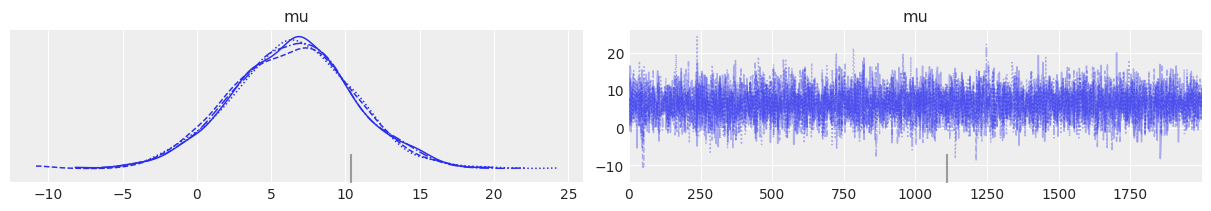

In [7]:
az.plot_trace(trace_h, var_names="mu");

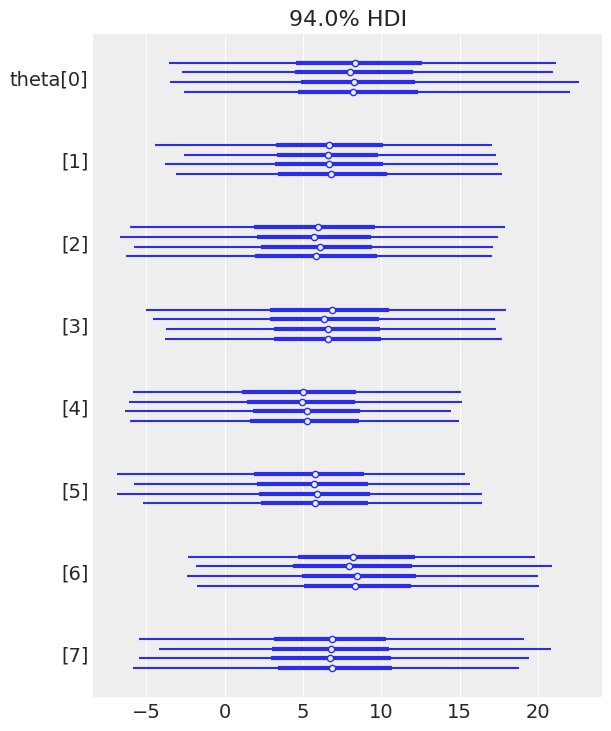

In [8]:
az.plot_forest(trace_h, var_names="theta");

### Leave-one-out Cross-validation (LOO)

LOO cross-validation is an estimate of the out-of-sample predictive fit. In cross-validation, the data are repeatedly partitioned into training and holdout sets, iteratively fitting the model with the former and evaluating the fit with the holdout data. Vehtari et al. (2016) introduced an efficient computation of LOO from MCMC samples (without the need for re-fitting the data). This approximation is based on importance sampling. The importance weights are stabilized using a method known as Pareto-smoothed importance sampling (PSIS).

### Widely-applicable Information Criterion (WAIC)

WAIC (Watanabe 2010) is a fully Bayesian criterion for estimating out-of-sample expectation, using the computed log pointwise posterior predictive density (LPPD) and correcting for the effective number of parameters to adjust for overfitting.

By default ArviZ uses LOO, but WAIC is also available.

In [9]:
pooled_loo = az.loo(trace_p, pooled)

pooled_loo.loo

-30.559179747247697

In [10]:
hierarchical_loo = az.loo(trace_h, hierarchical)

hierarchical_loo.loo

-30.76863810048652

ArviZ includes two convenience functions to help compare LOO for different models. The first of these functions is `compare`, which computes LOO (or WAIC) from a set of traces and models and returns a DataFrame.

In [11]:
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
pooled,0,-30.559180,0.673971,0.000000,1.0,1.102363,0.000000,False,log
hierarchical,1,-30.768638,1.112923,0.209458,0.0,1.067731,0.235049,False,log


We have many columns, so let's check out their meaning one by one:


0. The index is the names of the models taken from the keys of the dictionary passed to `compare(.)`.

1. **rank**, the ranking of the models starting from 0 (best model) to the number of models.

2. **loo**, the values of LOO (or WAIC). The DataFrame is always sorted from best LOO/WAIC to worst. 

3. **p_loo**, the value of the penalization term. We can roughly think of this value as the estimated effective number of parameters (but do not take that too seriously).

4. **d_loo**, the relative difference between the value of LOO/WAIC for the top-ranked model and the value of LOO/WAIC for each model. For this reason we will always get a value of 0 for the first model.

5. **weight**, the weights assigned to each model. These weights can be loosely interpreted as the probability of each model being true (among the compared models) given the data.

6. **se**, the standard error for the LOO/WAIC computations. The standard error can be useful to assess the uncertainty of the LOO/WAIC estimates. By default these errors are computed using stacking.

7. **dse**, the standard errors of the difference between two values of LOO/WAIC. The same way that we can compute the standard error for each value of LOO/WAIC, we can compute the standard error of the differences between two values of LOO/WAIC. Notice that both quantities are not necessarily the same, the reason is that the uncertainty about LOO/WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

8. **warning**, If `True` the computation of LOO/WAIC may not be reliable.

9. **loo_scale**, the scale of the reported values. The default is the log scale as previously mentioned. Other options are deviance -- this is the log-score multiplied by -2 (this reverts the order: a lower LOO/WAIC will be better) -- and negative-log -- this is the log-score multiplied by -1 (as with the deviance scale, a lower value is better).

The second convenience function takes the output of `compare` and produces a summary plot in the style of the one used in the book [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/) by Richard McElreath (check also [this port](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3) of the examples in the book to PyMC).

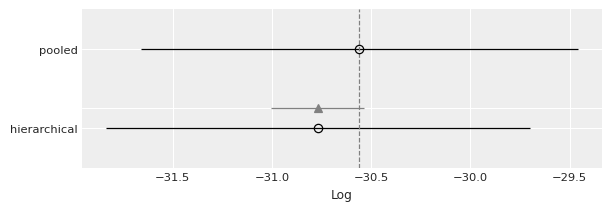

In [12]:
az.plot_compare(df_comp_loo, insample_dev=False);

The empty circle represents the values of LOO and the black error bars associated with them are the values of the standard deviation of LOO. 

The value of the highest LOO, i.e the best estimated model, is also indicated with a vertical dashed grey line to ease comparison with other LOO values.

For all models except the top-ranked one we also get a triangle indicating the value of the difference of WAIC between that model and the top model and a grey errobar indicating the standard error of the differences between the top-ranked WAIC and WAIC for each model.

### Interpretation

Though we might expect the hierarchical model to outperform a complete pooling model, there is little to choose between the models in this case, given that both models gives very similar values of the information criteria. This is more clearly appreciated when we take into account the uncertainty (in terms of standard errors) of LOO and WAIC.

## Reference

[Gelman, A., Hwang, J., & Vehtari, A. (2014). Understanding predictive information criteria for Bayesian models. Statistics and Computing, 24(6), 997–1016.](https://doi.org/10.1007/s11222-013-9416-2)

[Vehtari, A, Gelman, A, Gabry, J. (2016). Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC. Statistics and Computing](http://link.springer.com/article/10.1007/s11222-016-9696-4)

In [13]:
%watermark -n -u -v -iv -w -p xarray,aesara

Last updated: Thu Jan 13 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

xarray: 0.20.2
aesara: 2.3.2
aeppl : 0.0.18

matplotlib: 3.5.1
pymc      : 4.0.0b2
numpy     : 1.20.3
arviz     : 0.11.4

Watermark: 2.2.0

